In [218]:
import concurrent.futures
from collections import Counter
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
from matplotlib.colors import LogNorm

sns.set_theme(style="white", palette="bright")
sns.set_style("ticks")
plt.rcParams["font.family"] = "Inter"
plt.rcParams["figure.dpi"] = 150

image_dir: Path = Path("/media/zeevox/Documents/Felix/images")

In [219]:
def get_image_size(path: Path) -> tuple[int, int]:
    with Image.open(path) as im:
        return im.size

def parse_filename(file: Path) -> tuple[str, int]:
    # parse e.g. felix_1001-001 or felix-daily-2011_2-10
    issue, page = file.stem.rsplit("-", 1)
    return issue, int(page)

In [220]:
images = list(image_dir.iterdir())
with concurrent.futures.ThreadPoolExecutor() as executor:
    dimensions = list(executor.map(get_image_size, images))
widths, heights = zip(*dimensions)

In [221]:
frequency = Counter(dimensions)
for ((width, height), count) in frequency.most_common(5):
    print(f"{width}x{height}: {count}")

3485x4241: 8754
3485x4430: 4743
3367x4252: 2317
3414x4430: 928
3426x4371: 807


In [222]:
issues, pages = zip(*map(parse_filename, images))
df = pd.DataFrame({'file': images, 'issue': issues, 'page': pages, 'width': widths, 'height': heights})
df['pixels'] = df['width'] * df['height']
df.sample(10)

,file,issue,page,width,height,pixels
14512,/media/zeevox/Documents/Felix/images/felix_852...,felix_852,12,2550,3611,9208050
16095,/media/zeevox/Documents/Felix/images/felix_934...,felix_934,7,2537,3600,9133200
32518,/media/zeevox/Documents/Felix/images/felix_178...,felix_1787,7,3485,4241,14779885
19773,/media/zeevox/Documents/Felix/images/felix_139...,felix_1396,7,3485,4430,15438550
4416,/media/zeevox/Documents/Felix/images/felix_122...,felix_1224,15,2537,3579,9079923
34427,/media/zeevox/Documents/Felix/images/felix-dai...,felix-daily-2011_5,40,3485,4430,15438550
32663,/media/zeevox/Documents/Felix/images/felix_179...,felix_1793,1,3485,4241,14779885
34761,/media/zeevox/Documents/Felix/images/felix_141...,felix_1416,7,3485,4430,15438550
9911,/media/zeevox/Documents/Felix/images/felix_544...,felix_544,6,2527,3539,8943053
28243,/media/zeevox/Documents/Felix/images/felix_162...,felix_1625,3,3485,4241,14779885


In [223]:
df.sort_values(by='pixels', ascending=False)

,file,issue,page,width,height,pixels
7427,/media/zeevox/Documents/Felix/images/felix_328...,felix_328,3,7246,4945,35831470
7434,/media/zeevox/Documents/Felix/images/felix_329...,felix_329,3,7228,4898,35402744
7541,/media/zeevox/Documents/Felix/images/felix_342...,felix_342,3,6894,5054,34842276
7446,/media/zeevox/Documents/Felix/images/felix_330...,felix_330,3,7080,4916,34805280
7698,/media/zeevox/Documents/Felix/images/felix_359...,felix_359,5,6866,5051,34680166
...,...,...,...,...,...,...
378,/media/zeevox/Documents/Felix/images/felix_101...,felix_1014,20,1219,1744,2125936
1763,/media/zeevox/Documents/Felix/images/felix_107...,felix_1079,15,1749,1213,2121537
542,/media/zeevox/Documents/Felix/images/felix_102...,felix_1022,23,1689,1233,2082537
543,/media/zeevox/Documents/Felix/images/felix_102...,felix_1022,24,1689,1233,2082537


In [224]:
df[df.width > 6000]['issue'].drop_duplicates().sort_values()

18068    felix_1320
18089    felix_1321
18129    felix_1323
18145    felix_1324
18161    felix_1325
            ...    
7434      felix_329
7446      felix_330
7534      felix_341
7541      felix_342
7698      felix_359
Name: issue, Length: 244, dtype: object

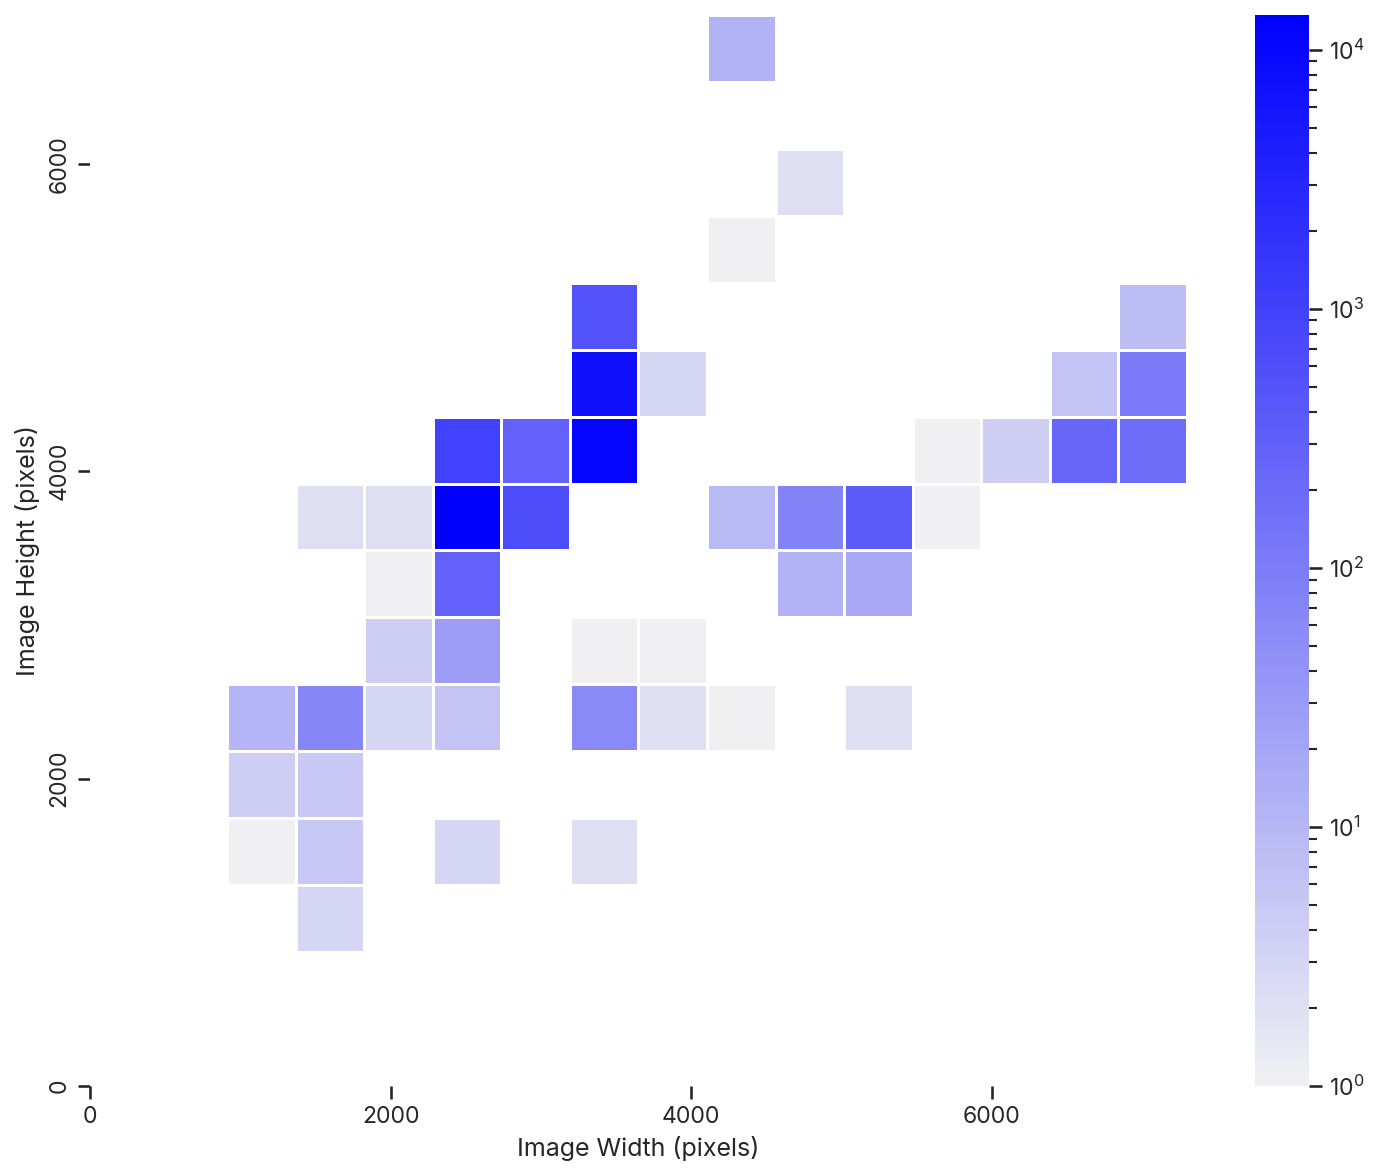

In [225]:
# Define the number of bins for width and height
num_bins = 16

# Compute a 2D histogram: bins start at zero and go to the maximum width/height
max_width = max(widths)
max_height = max(heights)
hist, xedges, yedges = np.histogram2d(
    widths, heights,
    bins=num_bins,
    range=[[0, max(widths)], [0, max(heights)]]
)

# cmap = sns.cubehelix_palette(start=0, rot=0, dark=0.1, light=1, reverse=False, as_cmap=True)

# Transpose the histogram so that x corresponds to width and y to height
hist_T = hist.T

# Mask out zeros so that empty bins appear as "bad" values in the colormap.
masked_hist = np.ma.masked_equal(hist_T, 0)

# Create a colormap that starts with white for "bad" values.
cmap = sns.light_palette("blue", as_cmap=True)
cmap.set_bad("white")

# Create a logarithmic normalisation, starting at 1 (to avoid log(0))
norm = LogNorm(vmin=1, vmax=hist.max())

plt.figure(figsize=(10, 8))
ax = sns.heatmap(masked_hist, cmap=cmap, norm=norm, cbar=True, linewidths=0.5)

# Invert y-axis so that (0,0) is at the bottom left
ax.invert_yaxis()

# Set custom tick labels every 2000 pixels
tick_interval = 2000

# Create arrays of pixel values for x and y ticks:
x_tick_values = np.arange(0, max_width + 1, tick_interval)
y_tick_values = np.arange(0, max_height + 1, tick_interval)

# Convert pixel tick values to bin positions:
x_tick_positions = x_tick_values / max_width * num_bins
y_tick_positions = y_tick_values / max_height * num_bins

ax.set_xticks(x_tick_positions)
ax.set_xticklabels(x_tick_values)
ax.set_yticks(y_tick_positions)
ax.set_yticklabels(y_tick_values)

plt.xlabel("Image Width (pixels)")
plt.ylabel("Image Height (pixels)")
# plt.title("Log-Scaled 2D Histogram of Image Resolutions")
plt.tight_layout()
# plt.show()
# plt.savefig("/home/zeevox/Downloads/resolutions.pdf")
plt.show()